In [293]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc, ticker
from mpl_toolkits.mplot3d import Axes3D
rc('animation', html='jshtml')

import scipy
from scipy import signal, linalg

import warnings
warnings.simplefilter("ignore")

from IPython.display import clear_output, HTML

# np.random.seed(1)
# random.seed(1)

import sys
sys.path.append("..")
sys.path.append("../shared")
sys.path.append("../IDL")

from wednesdaySPEED import simulation

import numba
from numba import njit, prange, jit

import entropy_estimators as ee

In [305]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def MI(s1, s2):
    l = len(s1)
    v1 = s1.reshape(l, 1)
    v2 = s2.reshape(l, 1)
    return ee.mi(v1, v2)

def visualiseNICE(G, P, N, S, X, D, T, U, C):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(
        ncols=1, nrows=8, figsize=(12,12), sharex=True, gridspec_kw = 
        {'wspace':0, 'hspace':0.05, 'height_ratios':[2,2,1,1,1,1,1,1]}
    )
    im1 = ax1.imshow(G.T, cmap="bone", interpolation="None", aspect="auto")
    im4 = ax4.imshow(P.T, cmap="hot", interpolation="None", aspect="auto")
    amnwc = np.max(np.abs(N-initial_account_balance))  # absolute max net worth change
    vmin, vmax = initial_account_balance-amnwc, initial_account_balance+amnwc
    im5 = ax5.imshow(N.T, cmap="bwr", interpolation="None", aspect="auto", vmin=vmin, vmax=vmax)

    size = "15%"

    cax1 = make_axes_locatable(ax1).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    cax4 = make_axes_locatable(ax4).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im4, cax=cax4, orientation='vertical')
    cax5 = make_axes_locatable(ax5).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im5, cax=cax5, orientation='vertical')

    cax2 = make_axes_locatable(ax2).append_axes('right', size=size, pad=0.05)
    cax2.hist(S, orientation="horizontal", bins=np.linspace(np.min(S), np.max(S), len(S)//2))
    # cax2.hist(np.log10(S), orientation="horizontal", bins=np.logspace(np.log10(np.min(S)), np.log10(np.max(S)), len(S)//2))
    # cax2.set_xscale("log")
    # cax2.set_yscale("log")
    cax2.get_xaxis().set_visible(False)
    cax2.get_yaxis().set_visible(False)

    cax3 = make_axes_locatable(ax3).append_axes('right', size=size, pad=0.05)
    cax3.hist(X, orientation="horizontal", bins=np.linspace(np.min(X), np.max(X), len(X)//5))
    cax3.get_xaxis().set_visible(False)
    cax3.get_yaxis().set_visible(False)

    cax6 = make_axes_locatable(ax6).append_axes('right', size=size, pad=0.05)
    cax6.get_xaxis().set_visible(False)
    cax6.get_yaxis().set_visible(False)
    cax7 = make_axes_locatable(ax7).append_axes('right', size=size, pad=0.05)
    cax7.get_xaxis().set_visible(False)
    cax7.get_yaxis().set_visible(False)
    cax8 = make_axes_locatable(ax8).append_axes('right', size=size, pad=0.05)
    cax8.get_xaxis().set_visible(False)
    cax8.get_yaxis().set_visible(False)

    # for ax in (ax2,ax3):
    #     cax = make_axes_locatable(ax).append_axes('right', size=size, pad=0.05)
    #     # cax.axis('off')

    ax2.set_yscale("log")
    ax2.plot(S, label="S")
    Ws = [25]
    for W in Ws:
        ax2.plot(np.arange(W-1, len(S)), moving_average(S, W), label=f"MA{W}")
    ax2.grid(alpha=0.4)
    # ax2.legend(ncol=len(Ws)+1)

    ax3.bar(np.arange(len(X)), X)
    ax3.grid(alpha=0.4)

    # if D.shape[1] < 25:
    # ax6.plot(np.mean(D[0],axis=1), color="C0", alpha=1, label="CA")
    # ax6.plot(np.mean(D[1],axis=1), color="C1", alpha=1, label="momentum")
    # ax6.plot(np.mean(D[2],axis=1), color="C2", alpha=1, label="invert")
    # ax6.plot(np.max(D[0],axis=1), ":", color="C0", alpha=1, label="CA")
    # ax6.plot(np.max(D[1],axis=1), ":", color="C1", alpha=1, label="momentum")
    # ax6.plot(np.max(D[2],axis=1), ":", color="C2", alpha=1, label="invert")
    # ax6.plot(np.min(D[0],axis=1), "--", color="C0", alpha=1, label="CA")
    # ax6.plot(np.min(D[1],axis=1), "--", color="C1", alpha=1, label="momentum")
    # ax6.plot(np.min(D[2],axis=1), "--", color="C2", alpha=1, label="invert")
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    # ax6.grid(alpha=0.4)
    # ax6.legend()

    # dfg = pd.DataFrame(G)
    # dfgt = pd.DataFrame(G.T)
    # # plt.figure(figsize=(12,2))
    # # data = dfg.groupby(pd.Grouper(freq="10D")).corr().mean()
    # original_length = G.shape[0]
    # window1 = 1
    # window2 = 10
    # array_length = original_length - window2
    # data1 = []
    # data2 = []
    # data3 = []
    # data4 = []
    # for i in range(0, array_length, window1):
    #     print(i, end=".")
    #     data1.append(dfg.iloc[i:i+window2].corr().mean().mean())
    #     data2.append(dfgt.iloc[:, i:i+window2].corr().mean().mean())
    #     data3.append(dfg.iloc[i:i+window2].corr(method=MI).mean().mean())
    #     data4.append(dfgt.iloc[:, i:i+window2].corr(method=MI).mean().mean())
    # data1 = (np.array(data1) - min(data1)) / (max(data1) - min(data1))
    # data2 = (np.array(data2) - min(data2)) / (max(data2) - min(data2))
    # data3 = (np.array(data3) - min(data3)) / (max(data3) - min(data3))
    # data4 = (np.array(data4) - min(data4)) / (max(data4) - min(data4))
    # ax6.plot(np.linspace(0, original_length, len(data1)), data1, label="Corr cell")
    # ax6.plot(np.linspace(0, original_length, len(data2)), data2, label="Corr time")
    # ax6.plot(np.linspace(0, original_length, len(data3)), data3, label="MI cell")
    # ax6.plot(np.linspace(0, original_length, len(data4)), data4, label="MI time")
    # ax6.grid(alpha=0.4)
    # ax6.legend(ncol=4)

    ax7.set_yscale("symlog")
    ax7.plot(T, label="stack")
    ax7.plot(U, label="called shares")
    ax7.grid(alpha=0.4)
    ax7.legend()

    signal = np.ones(shape=(9,9))
    signal[1:8,1:8] = 2.5
    signal[2:7,2:7] = 5
    signal[3:6,3:6] = 7.5
    signal[4,4] = 10

    convC = scipy.signal.convolve2d(C, signal)

    # if D.shape[1] < 25:
    #     ax6.plot(D, color="black", alpha=0.3)
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    ax8.imshow(convC.T, cmap="Reds", interpolation="None", aspect="auto")
    # ax6.grid(alpha=0.4)
    
    ax8.set_xlabel("time")
    # ax2.set_ylabel("standardised log returns")
    ax2.set_ylabel("close price")
    ax1.set_ylabel("agents")
    ax3.set_ylabel("log return")
    ax4.set_ylabel("portfolio")
    ax5.set_ylabel("net worth")
    ax6.set_ylabel("influence (I)")
    ax7.set_ylabel("stack")
    ax8.set_ylabel("margin calls")

    # fig.colorbar(im, cax=ax4)

    plt.tight_layout()
    # plt.savefig("tmp.png", dpi=300)
    plt.show()


In [306]:
# @njit(parallel=True)
# def forlooptest():
#     NN = 1000
#     meanX = np.zeros(shape=NN, dtype=np.float64)
#     for i in prange(10000):
#         # print(" " + str(i) + "_ ")
#         G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(
#             trigger = True, bound = True, pd = 0.025, pe = 0,
#             ph = 0.03, pa = 0.4, N0=1000, N1=100, A = 4, a=1, h=1, 
#             pi1 = 0.5, pi2 = 0.3, pi3 = 0.2, ub=1000, lb=20)
#         meanX[i] = np.mean(X)
#     return meanX

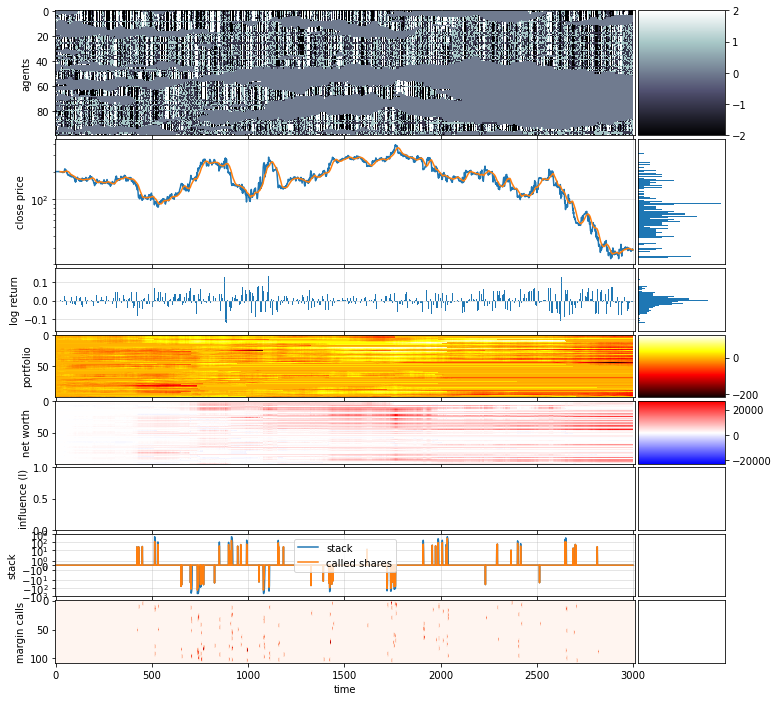

In [307]:
G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(
    trigger = False, bound = False, pd = 0.025, pe = 0,
    ph = 0.03, pa = 0.4, N0=3000, N1=100, A=4, a=1, h=1, 
    pi1 = 0.8, pi2 = 0.1, pi3 = 0.1, ub=1000, lb=20)

visualiseNICE(G, P, N, S, X, D, T, U, C)

TODO
- correlation / mutual information between clusters at time t, for each node over period t, for each cluster over period t, ...

In [273]:
df = pd.DataFrame(G.T)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

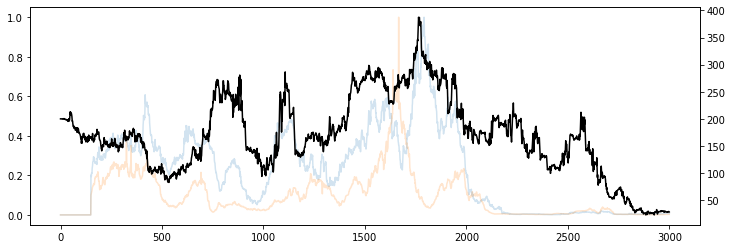

In [308]:
dfg = pd.DataFrame(G)
dfgt = pd.DataFrame(G.T)
fig, ax = plt.subplots(figsize=(12,4))
# plt.figure(figsize=(12,2))
# data = dfg.groupby(pd.Grouper(freq="10D")).corr().mean()
original_length = G.shape[0]
window1 = 10
window2 = 150
ND = 4
array_length = original_length - window2
data = np.zeros(shape=(4, original_length))
# for i in range(window2, original_length, window1):
for i in range(original_length):
    print(i, end=".")
    if i < window2:
        continue
    C1 = dfg.iloc[i-window2:i].corr()
    C2 = dfgt.iloc[:, i-window2:i].corr()

    data[0,i] = C1.mean().mean()
    data[1,i] = C2.mean().mean()
    data[2,i] = linalg.eigvals(C1.fillna(0).to_numpy())[3]**4
    data[3,i] = linalg.eigvals(C2.fillna(0).to_numpy())[3]**4

for i in range(ND):
    data[i] = (data[i] - min(data[i])) / (max(data[i]) - min(data[i]))
    
# ax.plot(data[0], label="Corr cell", alpha=0.2)
# ax.plot(data[1], label="Corr time", alpha=0.2)
ax.plot(data[2], label="Corr cell", alpha=0.2)
ax.plot(data[3], label="Corr time", alpha=0.2)

ax2 = ax.twinx()
ax2.plot(S, color="k")

In [265]:
df.iloc[:,0:0+10].corr(method=MI).mean(axis=0).sort_values()

6    0.416980
7    0.425687
8    0.432927
2    0.437249
4    0.441720
9    0.443496
0    0.495390
5    0.536293
1    0.573997
3    0.639705
dtype: float64

In [ ]:
# # G = np.zeros((10,10))
# # G[:,1] = 1
# # G[:,4] = 1
# # G[:,0] = 2
df = pd.DataFrame(G)

for i in range(0, 900, 50):
    plt.matshow(df[i:i+100].corr())
    print(df[i:i+100].corr().mean().mean())
    plt.show()
    clear_output(wait=True)
# df

In [269]:
dfgt = pd.DataFrame(G.T)
dfg = pd.DataFrame(G)

for i in range(0, 900, 10):
    plt.title(i)
    # plt.imshow(df.iloc[:, i:i+50].corr(),vmin=-1,vmax=1, cmap="bwr")
    # plt.figure.dpi=1
    dfgt.iloc[:,i:i+30].corr(method=MI).mean(axis=0).sort_values(ascending=False).plot(use_index=False)
    dfg.iloc[i:i+30].corr(method=MI).mean(axis=0).sort_values(ascending=False).plot(use_index=False)
    plt.show()
    clear_output(wait=True)

KeyboardInterrupt: 

In [179]:
%%capture

df = pd.DataFrame(G.T)

fig, ax = plt.subplots()
im = ax.imshow(df.iloc[:, 0:0+50].corr(), vmin=-1, vmax=1, cmap="bwr")
# ax.set_xticks(np.arange(N))
# ax.set_yticks(np.arange(N))
# ax.set_xticklabels(list(np.round(1*np.arange(N)/N, 2)))
# ax.set_yticklabels(list(np.round(1*np.arange(N)/N, 2)))
# ax.xaxis.set_ticks_position('bottom')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.set_title(f"Time $t={0:.3f}$")
# plt.tight_layout()

# ax.set_xlabel("$x$-axis [a.u.]")
# ax.set_ylabel("$y$-axis [a.u.]")

# cbar = fig.colorbar(im)
# cbar.set_label('Deflection', rotation=90)

# l = [0]+sorted(list(set(np.logspace(0, np.log10(len(Cl)), 300).astype(int))))

def animate(i):
    im.set_array(df.iloc[:, i:i+50].corr())
    # ax.set_title(f"Time $t={i:.3f}$")
    return (im,)
# 2*np.pi/freq

anim = animation.FuncAnimation(fig, animate, frames=range(0, 900, 1), blit=True)